### TFIDF + popular classifiers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score

import string

In [2]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
from tqdm import tqdm

fix_seed = 2024

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def get_train_val_test_split(X, y):
    X_train = X[X['subset'] == 'train']
    y_train = y[X['subset'] == 'train']
    
    X_val = X[X['subset'] == 'val']
    y_val = y[X['subset'] == 'val']
    
    X_test = X[X['subset'] == 'test']
    y_test = y[X['subset'] == 'test']
    
    X_train = X_train.drop('subset', axis=1)
    X_val = X_val.drop('subset', axis=1)
    X_test = X_test.drop('subset', axis=1)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
textual_dataset = pd.read_csv('textual_data_matched_split_version3.csv')
print(textual_dataset.shape)
textual_dataset.head()

(7214, 4)


,cik,label,subset,text
0,1476045,False,train,Chatham Lodging Trust is a REIT that invests i...
1,92352903,True,train,A cooperative bankshares corporation. The com...
2,833829,False,train,"Wind River, a global leader in Device Software..."
3,914789,False,train,"- Reported a 20% increase in revenue, driven b..."
4,853816,False,train,"Landstar System, Inc. is an asset-light provid..."


In [5]:
textual_dataset['text'] = textual_dataset['text'].apply(preprocess_text)
X = textual_dataset.drop(['cik', 'label'], axis=1)
y = textual_dataset['label']

X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_split(X, y)

X_train = X_train['text']
X_val = X_val['text']
X_test = X_test['text']

len(X_train), len(X_val), len(X_test)

(7170, 14, 30)

In [6]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

X_train_features.shape, X_test_features.shape

((7170, 1000), (30, 1000))

In [7]:
def get_classifiers(random_state=43):
    randomForestClassifier = RandomForestClassifier(random_state=random_state)
    gradientBoostingClassifier = GradientBoostingClassifier(random_state=random_state)
    adaBoostClassifier = AdaBoostClassifier(random_state=random_state)
    extraTreesClassifier = ExtraTreesClassifier(random_state=random_state)
    baggingClassifier = BaggingClassifier(random_state=random_state)
    logisticRegression = LogisticRegression(random_state=random_state, max_iter=300)
    svc = SVC(random_state=random_state)
    decisionTreeClassifier = DecisionTreeClassifier(random_state=random_state)
    kNeighborsClassifier = KNeighborsClassifier()
    gaussianNB = GaussianNB()
    mlpClassifier = MLPClassifier(hidden_layer_sizes=(16, 16),
                               batch_size=128,
                               max_iter=300,
                               shuffle=False,
                               random_state=random_state,
                               early_stopping=True,
                               beta_2=0.99,
                               n_iter_no_change=20
)
    
    return [randomForestClassifier, gradientBoostingClassifier, adaBoostClassifier, extraTreesClassifier, baggingClassifier, logisticRegression, svc, decisionTreeClassifier, kNeighborsClassifier, gaussianNB, mlpClassifier]

In [9]:
results = {}

for i in tqdm(range(1)):
    random_state = fix_seed + i
    classifiers = get_classifiers(random_state=random_state)
    
    for classifier in classifiers:
        classifier.fit(X_train_features.toarray(), y_train)
        y_pred = classifier.predict(X_test_features.toarray())
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        
        classifier_name = classifier.__class__.__name__
        if classifier_name not in results:
            results[classifier_name] = [[accuracy, precision]]
        else:
            results[classifier_name].append([accuracy, precision])
            
results_mean = {k: np.mean(v, axis=0) for k, v in results.items()}
results_mean = [[k] + v.tolist() for k, v in results_mean.items()]
results_df = pd.DataFrame(results_mean, columns=['classifier', 'accuracy', 'precision'])

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical core

In [ ]:
results_df

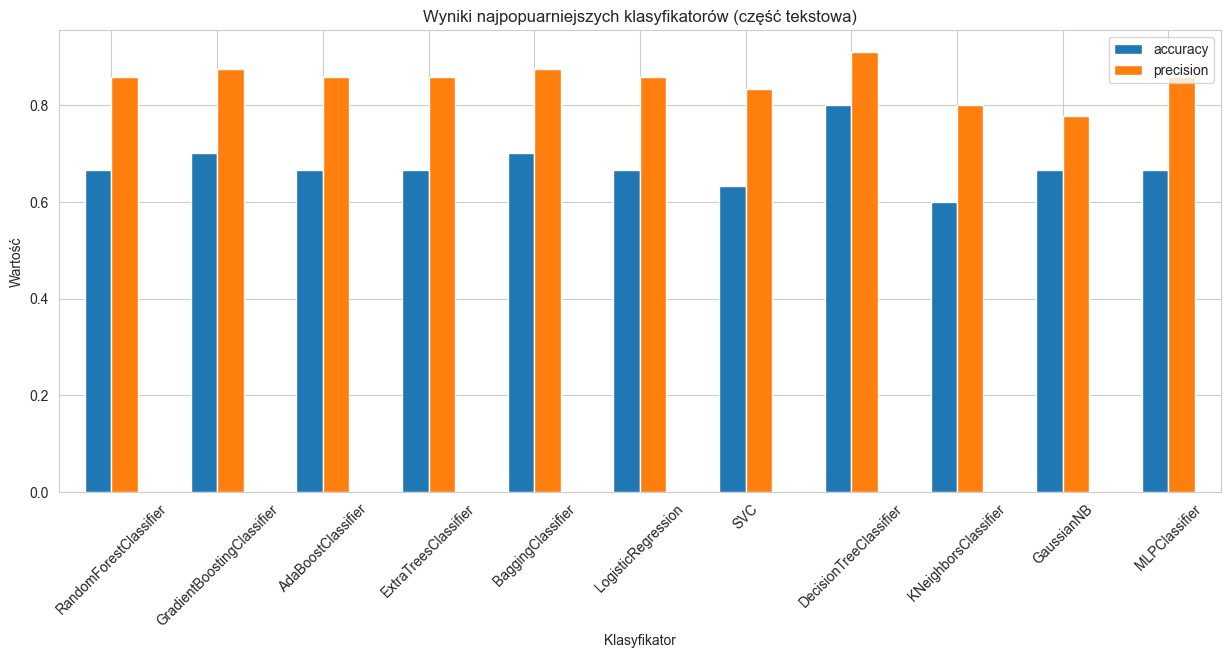

In [10]:
import matplotlib.pyplot as plt
results_df.plot(
    x='classifier',
    y=['accuracy', 'precision'],
    kind='bar',
    figsize=(15, 6),
    title='Wyniki najpopuarniejszych klasyfikatorów (część tekstowa)',
    xlabel='Klasyfikator',
    ylabel='Wartość')

plt.xticks(rotation=45)

plt.show()

## Huggingface models

In [50]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

### ROBERTA

In [51]:
def create_datasets(tokenizer, X_train, y_train, X_val, y_val, X_test, y_test, merge_train_and_val=False):
    
    def tokenize_function(texts):
        return tokenizer(texts, padding="max_length", truncation=True, max_length=256)
    
    if merge_train_and_val:
        X_train = pd.concat([X_train, X_val])
        y_train = pd.concat([y_train, y_val])
    else:
        val_encodings = tokenize_function(X_val.tolist())
        # y_val = y_val.apply(lambda x: 1 if x == True else 0)
    
    train_encodings = tokenize_function(X_train.tolist())
    test_encodings = tokenize_function(X_test.tolist())
    
    # y_train = y_train.apply(lambda x: 1 if x == True else 0)
    # y_test = y_test.apply(lambda x: 1 if x == True else 0)
    
    train_dataset = Dataset.from_dict({
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'labels': y_train.tolist()
    })
    
    if merge_train_and_val is False:
        eval_dataset = Dataset.from_dict({
            'input_ids': val_encodings['input_ids'],
            'attention_mask': val_encodings['attention_mask'],
            'labels': y_val.tolist()
        })
    else:
        eval_dataset = None
    
    test_dataset = Dataset.from_dict({
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'labels': y_test.tolist()
    })
    
    return train_dataset, eval_dataset, test_dataset

In [65]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    logits = torch.tensor(logits)
    labels = torch.tensor(labels)

    predictions = torch.argmax(logits, dim=-1)

    predictions = predictions.numpy()
    labels = labels.numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=1)
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [53]:
def get_trainer(model, train_dataset, eval_dataset):
    training_args = TrainingArguments(
        output_dir="./results/finbert",
        eval_strategy="steps",
        save_steps=449,
        eval_steps=449,
        logging_steps=449,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=1,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="precision",
        greater_is_better=True
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics
    )
    
    return trainer

3:40 min - 3 epoki batch size 8

2:20 min - 2 epoki batch size 16, tokenizer 256

X: - 3 epoki batch size 32, tokenizer 256

In [10]:
robertaTokenizer = RobertaTokenizer.from_pretrained("roberta-base")
robertaForSequenceClassification = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
train_dataset, eval_dataset, test_dataset = create_datasets(robertaTokenizer, X_train, y_train, X_val, y_val, X_test, y_test)
trainer = get_trainer(robertaForSequenceClassification, train_dataset, eval_dataset)

In [12]:
trainer.train()

robertaForSequenceClassification.save_pretrained("./saved_model/roberta-base")
robertaTokenizer.save_pretrained("./saved_model/roberta-base")

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
256,0.246300,1.732081,0.571429,0.666667,0.285714,0.400000
512,0.178900,1.301236,0.642857,1.000000,0.285714,0.444444
768,0.124800,1.585025,0.642857,1.000000,0.285714,0.444444
1024,0.089600,1.726819,0.642857,1.000000,0.285714,0.444444
1280,0.083800,1.854014,0.642857,1.000000,0.285714,0.444444


('./saved_model/roberta-base\\tokenizer_config.json',
 './saved_model/roberta-base\\special_tokens_map.json',
 './saved_model/roberta-base\\vocab.json',
 './saved_model/roberta-base\\merges.txt',
 './saved_model/roberta-base\\added_tokens.json')

In [16]:
trainer.evaluate()

{'eval_loss': 1.301235556602478,
 'eval_accuracy': 0.6428571428571429,
 'eval_precision': 1.0,
 'eval_recall': 0.2857142857142857,
 'eval_f1': 0.4444444444444444,
 'eval_runtime': 2.5828,
 'eval_samples_per_second': 5.42,
 'eval_steps_per_second': 5.42,
 'epoch': 3.0}

In [13]:
trainer.evaluate(test_dataset)

{'eval_loss': 1.3315991163253784,
 'eval_accuracy': 0.6333333333333333,
 'eval_precision': 1.0,
 'eval_recall': 0.26666666666666666,
 'eval_f1': 0.42105263157894735,
 'eval_runtime': 5.5567,
 'eval_samples_per_second': 5.399,
 'eval_steps_per_second': 5.399,
 'epoch': 3.0}

In [14]:
model = RobertaForSequenceClassification.from_pretrained("./saved_model/roberta-base")
tokenizer = RobertaTokenizer.from_pretrained("./saved_model/roberta-base")

In [15]:
texts = ["The company is bankrupt", "The company is doing well"]

inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=-1)

print(predictions)

tensor([1, 0])


### FinBert

we need to map label to models labels:
False -> negative
True -> positive

In [54]:
textual_dataset = pd.read_csv('textual_data_matched_split_version3.csv')
print(textual_dataset.shape)
textual_dataset.head()

(7214, 4)


,cik,label,subset,text
0,1476045,False,train,Chatham Lodging Trust is a REIT that invests i...
1,92352903,True,train,A cooperative bankshares corporation. The com...
2,833829,False,train,"Wind River, a global leader in Device Software..."
3,914789,False,train,"- Reported a 20% increase in revenue, driven b..."
4,853816,False,train,"Landstar System, Inc. is an asset-light provid..."


In [55]:
textual_dataset['label'] = textual_dataset['label'].apply(lambda x: 2 if x == True else 0)
textual_dataset.head()

,cik,label,subset,text
0,1476045,0,train,Chatham Lodging Trust is a REIT that invests i...
1,92352903,2,train,A cooperative bankshares corporation. The com...
2,833829,0,train,"Wind River, a global leader in Device Software..."
3,914789,0,train,"- Reported a 20% increase in revenue, driven b..."
4,853816,0,train,"Landstar System, Inc. is an asset-light provid..."


In [56]:
textual_dataset['text'] = textual_dataset['text'].apply(preprocess_text)
X = textual_dataset.drop(['cik', 'label'], axis=1)
y = textual_dataset['label']

X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_split(X, y)

X_train = X_train['text']
X_val = X_val['text']
X_test = X_test['text']

len(X_train), len(X_val), len(X_test)

(7170, 14, 30)

In [57]:
finbertTokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
prosusAIFinbert = BertForSequenceClassification.from_pretrained('ProsusAI/finbert', num_labels=3)

C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [58]:
train_dataset, eval_dataset, test_dataset = create_datasets(finbertTokenizer, X_train, y_train, X_val, y_val, X_test, y_test)

In [59]:
trainer = get_trainer(prosusAIFinbert, train_dataset, eval_dataset)

In [61]:
trainer.train()

robertaForSequenceClassification.save_pretrained("./saved_model/finbert")
robertaTokenizer.save_pretrained("./saved_model/finbert")

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
449,0.226900,0.837802,0.714286,0.818182,0.714286,0.688889
898,0.119100,1.799599,0.642857,0.791667,0.642857,0.590643
1347,0.071700,1.824605,0.642857,0.791667,0.642857,0.590643


('./saved_model/finbert\\tokenizer_config.json',
 './saved_model/finbert\\special_tokens_map.json',
 './saved_model/finbert\\vocab.json',
 './saved_model/finbert\\merges.txt',
 './saved_model/finbert\\added_tokens.json')

In [62]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.8475218415260315,
 'eval_accuracy': 0.7,
 'eval_precision': 0.7556818181818182,
 'eval_recall': 0.7,
 'eval_f1': 0.6827262044653349,
 'eval_runtime': 5.3163,
 'eval_samples_per_second': 5.643,
 'eval_steps_per_second': 5.643,
 'epoch': 3.0}